In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu2'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 6
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu2,get_pyramid_dataset,lanczos,False,6,True,True


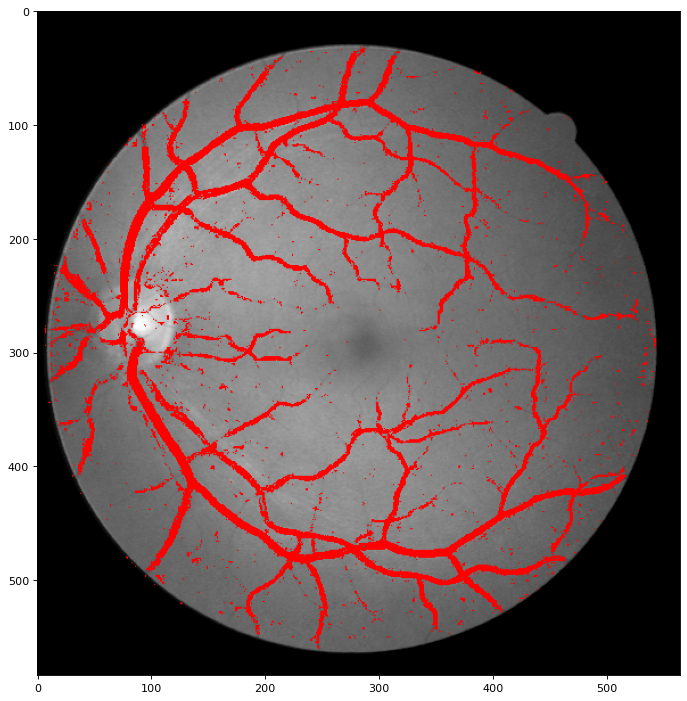

Accuracy score: 0.926319450916448

F1 score: 0.7063262482706577

Confusion matrix:

     t/p      0     1 
        0 1141558 45987 
        1 54418 120744 
Sensivity: 0.6893275938845184
Specificity: 0.9612755727151392


(0.926, 0.706, 1141558, 45987, 54418, 120744)

In [2]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=True, plot_once=True, add_channels=False, recurrence=False)

In [3]:
# Get train and test dataframes for feature selection

from main import load_datasets_for_lbp_operator

for i, lbp_operator in enumerate(['default', 'riu', 'riu2', 'nriuniform', 'var']):
    PARAMETERS.LBP_METHOD = lbp_operator
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    if i == 0:
        df_train, df_test, y_train, y_test = load_datasets_for_lbp_operator('../')
    else:
        temp_datasets = load_datasets_for_lbp_operator('../', discard_columns=True)
        df_train = pd.concat([df_train, temp_datasets[0]], axis=1)
        df_test = pd.concat([df_test, temp_datasets[1]], axis=1)
        
features = {'x_train': df_train, 'x_test': df_test, 'y_train': y_train, 'y_test': y_test}

In [4]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])

In [11]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_feature_removal(removal_col_types, features, verbose=False):
    if isinstance(removal_col_types, str):
        removal_col_types = [removal_col_types]
    remove_list = []
    for col_type in removal_col_types:
        remove_list += [c for c in df_train.columns if col_type in c]
    for col_type in removal_col_types:
        if 'radius' in col_type:
            remove_list += [c for c in df_train.columns if ('conv' not in c and c.endswith(f'_{col_type[-1]}'))]
    
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp.drop(columns=remove_list), y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :].drop(columns=remove_list))
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


def cv_feature_removal(col_types, features):
    best_f1 = 0
    diff = 0
    removal_list = []
    threshold = 0.005
    while True:
        print(removal_list)
        f1_dict = {}
        for col_type in col_types:
            if col_type not in removal_list:
                print(col_type)
                f1_dict[col_type] = test_feature_removal(removal_list + [col_type], features)['f1']
        display(pd.DataFrame(f1_dict, index=[0]))
        reverse_f1_dict = {v: k for k, v in f1_dict.items()}
        diff = best_f1 - max(list(f1_dict.values())) if best_f1 != 0 else 0
        if diff < threshold:
            v = max(list(f1_dict.values()))
            best_f1 = max(best_f1, v)
            removal_list.append(reverse_f1_dict[v])
        else:
            break

    print('-------------------------')
    print(removal_list)

In [12]:
display(df_train.columns)

# Scales
col_types = ['2:1', '1:1', '1:2', '1:4', '1:8', '1:16']
# LBP operators
col_types += ['default_', 'riu_', 'riu2_', 'nriuniform_', 'var_']
# Gray scale
col_types += ['Original']

Index(['Original', 'default_1:1', 'default_1:2', 'default_1:4', 'default_1:8',
       'default_1:16', 'default_2:1_1', 'default_2:1_2', 'default_2:1_3',
       'default_2:1_4', 'riu_1:1', 'riu_1:2', 'riu_1:4', 'riu_1:8', 'riu_1:16',
       'riu_2:1_1', 'riu_2:1_2', 'riu_2:1_3', 'riu_2:1_4', 'riu2_1:1',
       'riu2_1:2', 'riu2_1:4', 'riu2_1:8', 'riu2_1:16', 'riu2_2:1_1',
       'riu2_2:1_2', 'riu2_2:1_3', 'riu2_2:1_4', 'nriuniform_1:1',
       'nriuniform_1:2', 'nriuniform_1:4', 'nriuniform_1:8', 'nriuniform_1:16',
       'nriuniform_2:1_1', 'nriuniform_2:1_2', 'nriuniform_2:1_3',
       'nriuniform_2:1_4', 'var_1:1', 'var_1:2', 'var_1:4', 'var_1:8',
       'var_1:16', 'var_2:1_1', 'var_2:1_2', 'var_2:1_3', 'var_2:1_4'],
      dtype='object')

In [13]:
cv_feature_removal(col_types, features)

[]
2:1
1:1
1:2
1:4
1:8
1:16
default_
riu_
riu2_
nriuniform_
var_
Original


,2:1,1:1,1:2,1:4,1:8,1:16,default_,riu_,riu2_,nriuniform_,var_,Original
0,0.655669,0.664919,0.63659,0.652706,0.665487,0.670816,0.665757,0.664036,0.663936,0.663886,0.496326,0.63637


['1:16']
2:1
1:1
1:2
1:4
1:8
default_
riu_
riu2_
nriuniform_
var_
Original


,2:1,1:1,1:2,1:4,1:8,default_,riu_,riu2_,nriuniform_,var_,Original
0,0.660221,0.664978,0.641371,0.660163,0.667397,0.670908,0.669242,0.67233,0.671647,0.497737,0.638884


['1:16', 'riu2_']
2:1
1:1
1:2
1:4
1:8
default_
riu_
nriuniform_
var_
Original


,2:1,1:1,1:2,1:4,1:8,default_,riu_,nriuniform_,var_,Original
0,0.659918,0.666157,0.641787,0.660637,0.667116,0.671116,0.670373,0.670964,0.499375,0.639446


['1:16', 'riu2_', 'default_']
2:1
1:1
1:2
1:4
1:8
riu_
nriuniform_
var_
Original


,2:1,1:1,1:2,1:4,1:8,riu_,nriuniform_,var_,Original
0,0.662102,0.663417,0.639185,0.658411,0.66632,0.666378,0.668632,0.485227,0.63861


['1:16', 'riu2_', 'default_', 'nriuniform_']
2:1
1:1
1:2
1:4
1:8
riu_
var_
Original


,2:1,1:1,1:2,1:4,1:8,riu_,var_,Original
0,0.661113,0.663645,0.640094,0.658105,0.66361,0.575716,0.456756,0.634629


-------------------------
['1:16', 'riu2_', 'default_', 'nriuniform_']


### Características descartadas
['1:16', 'riu2_', 'default_', 'nriuniform_']


### Resultado CV

F1-score 0.668632

### Selección de características

- riu
- var
- 2:1
- 1:1
- 1:2
- 1:4
- 1:8
- Original (intensidad de gris)